In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [3]:
grayImage = r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\albert-einstein_gray.jpg'
affineWarped = r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\affine-transformed image.jpg'

In [4]:
I_gray = cv2.imread(grayImage, cv2.IMREAD_GRAYSCALE)
I_affinedWarp = cv2.imread(affineWarped, cv2.IMREAD_GRAYSCALE)

In [5]:
def f_getPoints(I, numPts):
    %matplotlib
    fig, ax = plt.subplots(1, figsize=(15,30))
    plt.imshow(I, cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts)))
    pts = pts[:, [1,0]].T
    plt.close()
    return pts

In [22]:
# Compute P set of points
P = f_getPoints(I_gray, 3)

Using matplotlib backend: TkAgg


In [23]:
P

array([[397., 401., 484.],
       [325., 496., 441.]])

In [24]:
P_dash = f_getPoints(I_affinedWarp, 3)

Using matplotlib backend: TkAgg


In [25]:
P_dash

array([[406., 397., 478.],
       [320., 429., 418.]])

In [26]:
P = np.vstack((P, np.ones((1,3))))
P

array([[397., 401., 484.],
       [325., 496., 441.],
       [  1.,   1.,   1.]])

In [27]:
P_dash = np.vstack((P_dash, np.ones((1,3))))
P_dash

array([[406., 397., 478.],
       [320., 429., 418.],
       [  1.,   1.,   1.]])

In [28]:
np.linalg.det(P)

-14412.999999999998

In [29]:
A = P_dash.dot(np.linalg.inv(P))
A

array([[ 9.26663429e-01, -7.43079165e-02,  6.22646916e+01],
       [ 2.85436758e-01,  6.30750017e-01,  1.68785125e+00],
       [ 1.73472348e-18, -1.40946282e-18,  1.00000000e+00]])

In [30]:
def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    fig_size = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

def bilinearInterpolation(r, c, I):
   
    # Column indexes
    lc = int(c) # left column
    rc = lc+1   # right column

    # Row indexes
    tr = int(r) # top row
    br = tr + 1 # bottom row

    # Weights of horizontal linear indexes
    wr = c - lc
    wl = rc - c

    # Weights of vertical linear indexes
    wt = br - r
    wb = r - tr

    if tr >= 0 and br < I.shape[0] and lc >= 0 and rc < I.shape[1]:  
        # Intensity alpha (top row linear)
        a = I[tr, lc] * wl + I[tr, rc] * wr
        # Intensity betha (bottom row linear)
        b = I[br, lc] * wl + I[br, rc] * wr

        # Final intensity (vertical linear)
        f = a * wt + b * wb

        return np.uint8(f)
    else:
        return 0
def getExtentsProjective(T, rMax, cMax):
    cords = np.array([[0,0,1], [0, cMax-1, 1], [rMax, 0, 1], [rMax, cMax, 1]])
    A_dash = T.dot(cords.T)
    A_dash = A_dash/A_dash[2,:]

    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)

    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))

    # Define height and width
    H, W = maxR - minR + 1, maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

def transformProjective(T, I_gray):
    Tinv = np.linalg.inv(T)

    numRows = I_gray.shape[0]
    numCols = I_gray.shape[1]

    minR, minC, maxR, maxC, H, W = getExtentsProjective(T, I_gray.shape[0], I_gray.shape[1])

    I2 = np.zeros((H,W), dtype='uint8')

    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i,new_j, 1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            # Bilinear interpolation
            P = np.int16(np.round(P))
            i, j = P[0], P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = bilinearInterpolation(i,j,I_gray)
                I2[new_i - minR, new_j - minC] = g
    return I2


In [31]:
I2 = transformProjective(A, I_gray)

In [32]:
plt.imshow(I2, cmap='gray')

# Affine Transformation Estimation with many points

In [33]:
# Compute P set of points
P = f_getPoints(I_gray, 5)
P

Using matplotlib backend: TkAgg


array([[397., 399., 484., 564., 564.],
       [321., 498., 439., 475., 349.]])

In [35]:
P_dash = f_getPoints(I_affinedWarp, 5)
P_dash

Using matplotlib backend: TkAgg


array([[408., 395., 483., 549., 565.],
       [315., 429., 416., 462., 386.]])

In [37]:
P = np.vstack((P, np.ones((1,5))))
P

array([[397., 399., 484., 564., 564.],
       [321., 498., 439., 475., 349.],
       [  1.,   1.,   1.,   1.,   1.]])

In [38]:
P_dash = np.vstack((P_dash, np.ones((1,5))))
P_dash

array([[408., 395., 483., 549., 565.],
       [315., 429., 416., 462., 386.],
       [  1.,   1.,   1.,   1.,   1.]])

In [39]:
A = P_dash.dot(P.T).dot(np.linalg.inv(P.dot(P.T)))
A

array([[ 9.38563923e-01, -9.50321883e-02,  6.75590181e+01],
       [ 3.03833244e-01,  6.27426294e-01, -5.98639885e+00],
       [-1.73472348e-17,  0.00000000e+00,  1.00000000e+00]])

In [40]:
I2 = transformProjective(A, I_gray)

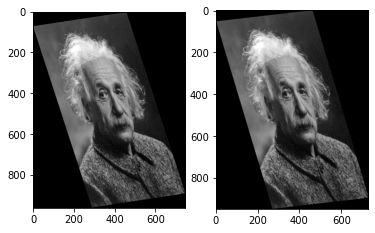

In [44]:
%matplotlib inline
plt.figure(1)
plt.subplot(121)
plt.imshow(I2, cmap='gray')
plt.subplot(122)
plt.imshow(I_affinedWarp, cmap="gray")